# UNet in Tensorflow

### By Farzam

    1. Packages
    2. Helper Functions for data processing
        2.1. Load data
        2.2. Pre-process data
    3. UNet
        3.1. Encoder Block
        3.2. Decoder Block
        3.3. Compiling UNet
    4. Data Understanding
        4.1. Data Sampling
        4.2. Data Prepration
        4.3. Data Split into Train and Test
    5. Training data
    6. Visualizing the results
    7. Saving the model (for future weight transfer)

<a name='1'></a>
# 1 - Packages

In [1]:
# for data load
import os

# for reading and processing images
import imageio
from PIL import Image

# for visualizations
import matplotlib.pyplot as plt

import numpy as np # for using np arrays

from tqdm import tqdm

# for bulding and running deep learning model
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

2023-07-21 14:33:28.516911: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<a name='2'></a>
# 2 - Helper Functions for Data Processing

<a name='2.1'></a>
## 2.1 - Load Data
* The masked images are stored as png, unmasked (original) as jpg
* The names of these 2 are same so for getting the right sample we can just sort the 2 lists

In [2]:
def LoadData(path1, path2):
    """
    Looks for relevant filenames in the shared path
    Returns 2 lists for original and masked files respectively
    
    """
    # Read the images folder like a list
    image_dataset = os.listdir(path1)
    mask_dataset = os.listdir(path2)

    # Make a list for images and masks filenames
    orig_img = []
    mask_img = []
    for img in image_dataset:
        orig_img.append(img)
        
    for mask in mask_dataset:
        mask_img.append(mask)
    
    # Sort the lists to get both of them in same order (the dataset has exactly the same name for images and corresponding masks)
    orig_img.sort()
    mask_img.sort()
    
    return orig_img, mask_img

<a name='2.2'></a>
## 2.2 - Pre-Process Data

In [19]:
def PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2):
    """
    Processes the images and mask present in the shared list and path
    Returns a NumPy dataset with images as 3-D arrays of desired size
    Please note the masks in this dataset have only one channel
    """
    # Pull the relevant dimensions for image and mask
    m = len(img)
    
    # Getting image's config
    img_height, img_width, img_channel = target_shape_img   
    
    # Getting mask's config
    mask_height, mask_width, mask_channel = target_shape_mask
    
    # Define X and Y as number of images along with shape of one image
    X = np.zeros((m, img_height, img_width, img_channel), dtype=np.float32)
    y = np.zeros((m, mask_height, mask_width, mask_channel), dtype=np.int32)
    
    # Resize images and masks
    for idx, file in enumerate(tqdm(img)):
        # convert image into an array of desired shape (3 channels)
        try:
            path = os.path.join(path1, file)
            
            # Reading the image using PIL
            single_img = Image.open(path).convert('RGB')
            
            # Resizing the image
            single_img = single_img.resize((img_height, img_width))
            
            # Rehaping the image
            single_img = np.reshape(single_img,(img_height, img_width, img_channel))
            
            # Scaling the image to have values between 0 and 1 (Normalizing them actually)
            single_img = single_img / 256.0
            
            # Replacing the values of zero-elements in the X array with the resized-scaled image.
            X[idx] = single_img

            # convert mask into an array of desired shape (1 channel)
            single_mask_ind = mask[idx]
            
            path = os.path.join(path2, single_mask_ind)
            
            # Reading the mask (soft mask here in thge PETS dataset)
            single_mask = Image.open(path)
            
            # Resizing the mask
            single_mask = single_mask.resize((mask_width, mask_width))
            
            # Reshaping the mask into the original shape
            single_mask = np.reshape(single_mask,(mask_height, mask_width, mask_channel)) 
            
            # Subtracting 1 from single_mask variable to make sure classes start from 0.
            single_mask = single_mask - 1
            
            # Replacing the Y[idx] with the reshaped-rescaled mask
            y[idx] = single_mask
        except:
            # Error detection in case if any error happens!
            print(f'{file}-{single_mask_ind}')
    return X, y

# 3 - Constructing the U-Net Architecture


![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

<a name='3.1'></a>
## 3.1 - U-Net Encoder Block

In [4]:
def EncoderMiniBlock(inputs, n_filters=64, dropout_prob=0.3, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning. 
    Dropout can be added for regularization to prevent overfitting. 
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    # Add 2 Conv Layers with relu activation and HeNormal initialization using TensorFlow 
    # Proper initialization prevents from the problem of exploding and vanishing gradients 
    # 'Same' padding will pad the input to conv layer such that the output has the same height and width (hence, is not reduced in size) 
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='HeNormal')(inputs)
    
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='HeNormal')(conv)
    
    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv, training=False)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Pooling reduces the size of the image while keeping the number of channels same
    # Pooling has been kept as optional as the last encoder layer does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output computation and uses stride of 2 to traverse across input image
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions      
    skip_connection = conv
    
    return next_layer, skip_connection

<a name='3.2'></a>
## 3.2 - U-Net Decoder Block

In [20]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    p = Conv2DTranspose(n_filters, (3,3), strides=(2,2), padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = concatenate([up, skip_layer_input], axis=3)
    
    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='HeNormal')(conv)
    return conv

<a name='3.3'></a>
## 3.3 - Compile U-Net Blocks

In [6]:
def UNetCompiled(input_size=(128, 128, 3), n_filters=32, n_classes=3):
    """
    Combine both encoder and decoder blocks according to the U-Net research paper
    Return the model as output 
    """
    # Input size represent the size of 1 image (the size used for pre-processing) 
    inputs = Input(input_size)
    
    # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image 
    cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
    cblock2 = EncoderMiniBlock(cblock1[0], n_filters * 2, dropout_prob=0, max_pooling=True)
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters * 4, dropout_prob=0, max_pooling=True)
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters * 8, dropout_prob=0.3, max_pooling=True)
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters * 16, dropout_prob=0.3, max_pooling=False) 
    
    # Decoder includes multiple mini blocks with decreasing number of filters
    # Observe the skip connections from the encoder are given as input to the decoder
    # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1], n_filters * 8)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1], n_filters * 4)
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1], n_filters * 2)
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1], n_filters)

    # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
    # Followed by a 1x1 Conv layer to get the image to the desired size. 
    # Observe the number of channels will be equal to number of output classes
    conv9 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(ublock9)
    
    # Since the mask will be a binary output we have a sigmoid activation function.
    conv10 = Conv2D(n_classes, 1, padding='same', activation='sigmoid')(conv9)
    
    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

<a name='4'></a>
# 4 - Executing above Functions to Train the Model

<a name='4.1'></a>
## 4.1 - Load and View Data

/tmp/624780.tinygpu/ipykernel_663744/2839853971.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_view  = imageio.imread(path1 + img[i])
/tmp/624780.tinygpu/ipykernel_663744/2839853971.py:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask_view = imageio.imread(path2 + mask[i])


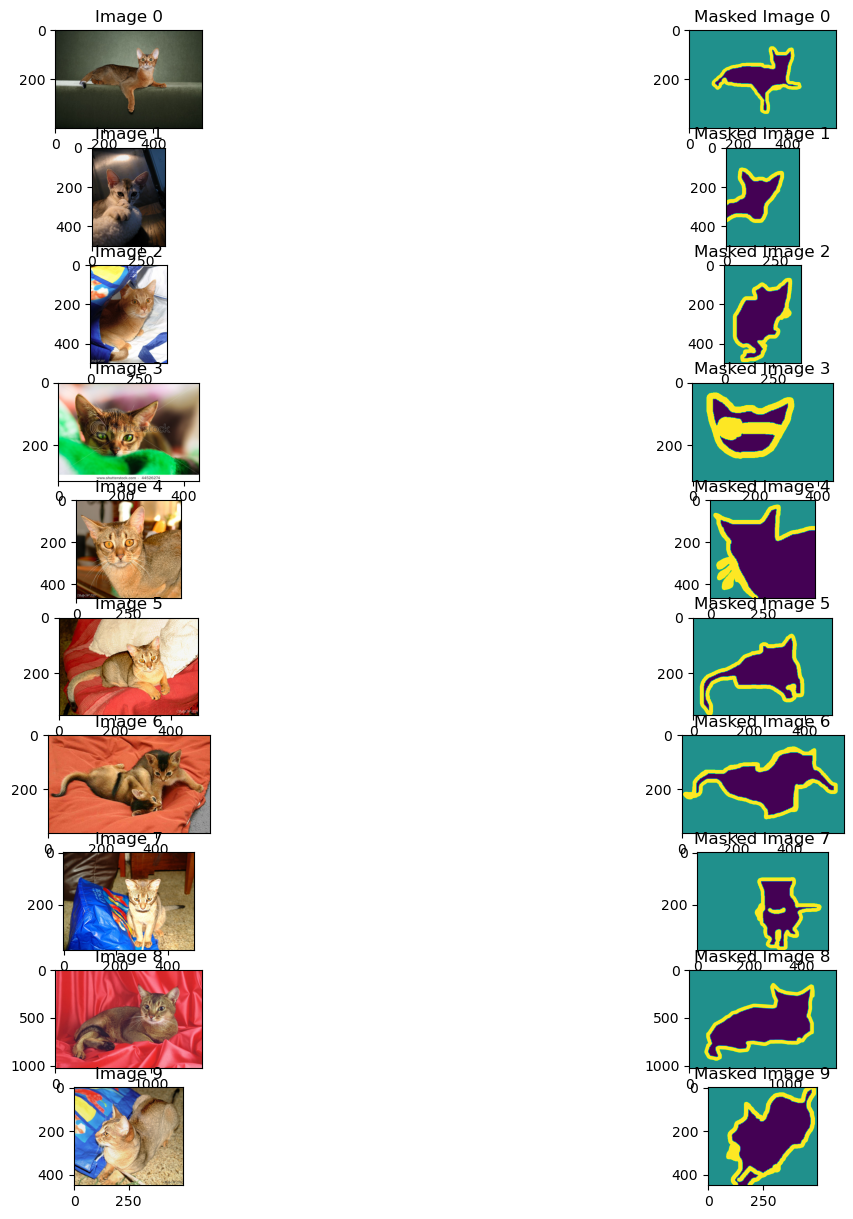

In [7]:
""" Load Train Set and view some examples """
# Call the apt function

# Path to our images, here the PETS dataset.
path1 = './../data/images/'

# Path to the masks.
path2 = './../data/annotations/trimaps/'

# Creating arrays for X, Y.
img, mask = LoadData(path1, path2)

# View examples of image and corresponding masks
show_images = 10

fig, arr = plt.subplots(show_images, 2, figsize=(15, 15))
    
for i in range(show_images):
    img_view  = imageio.imread(path1 + img[i])
    mask_view = imageio.imread(path2 + mask[i])
    
    arr[i][0].imshow(img_view)
    arr[i][0].set_title('Image '+ str(i))
    arr[i][1].imshow(mask_view)
    arr[i][1].set_title('Masked Image '+ str(i))

<a name='4.2'></a>
## 4.2 - Process Data

100%|██████████| 7390/7390 [04:04<00:00, 30.28it/s]


X Shape: (7390, 256, 256, 3)
Y shape: (7390, 256, 256, 1)
[0 1 2]


Text(0.5, 1.0, 'Processed Masked Image ')

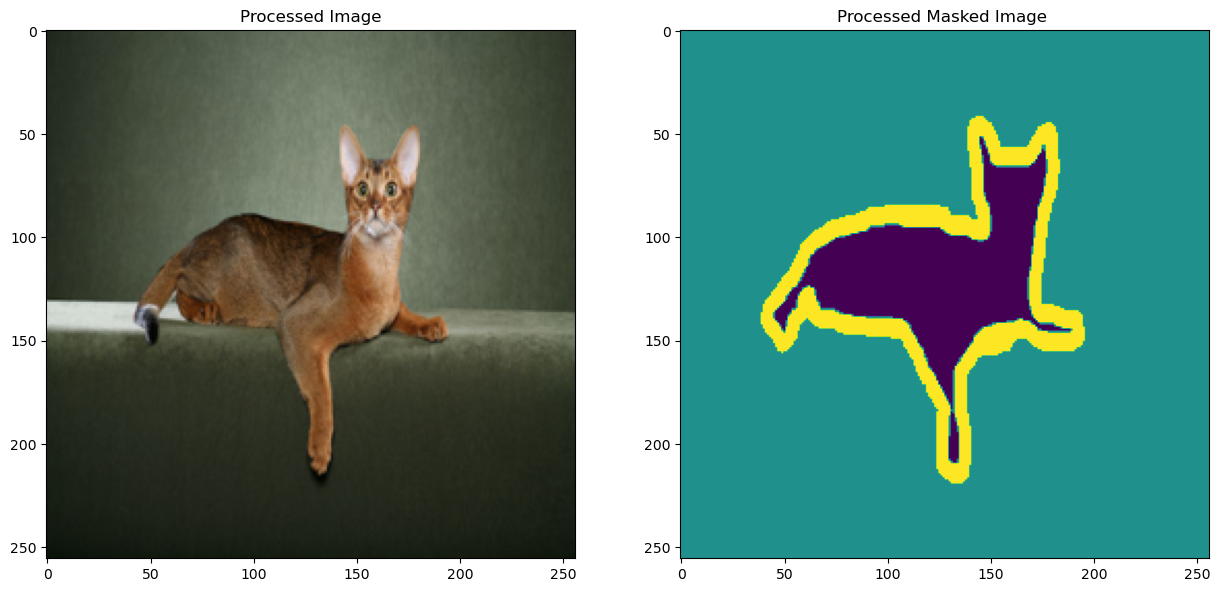

In [8]:
# Define the desired shape
target_shape_img = [256, 256, 3]
target_shape_mask = [256, 256, 1]

# Process data using apt helper function
X, y = PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2)

print("X Shape:", X.shape)
print("Y shape:", y.shape)

# There are 3 classes : background, pet, outline
print(np.unique(y))

# Visualize the output for first image.
image_index = 0

fig, arr = plt.subplots(1, 2, figsize=(15, 15))

arr[0].imshow(X[image_index])
arr[0].set_title('Processed Image')
arr[1].imshow(y[image_index,:,:,0])
arr[1].set_title('Processed Masked Image ')

## 4.3 - Split Train and Test Set

In [9]:
# Use scikit-learn's function to split the dataset
# Here, I have used 20% data as test/valid set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_valid.shape}')

print(f'Y_train: {y_train.shape}')
print(f'Y_test: {y_valid.shape}')

X_train: (5912, 256, 256, 3)
X_test: (1478, 256, 256, 3)
Y_train: (5912, 256, 256, 1)
Y_test: (1478, 256, 256, 1)


In [10]:
# Define the strategy for distributing the training across GPUs
strategy = tf.distribute.MirroredStrategy()

# Create a distributed training context
with strategy.scope():
    # Call the helper function for defining the layers for the model, given the input image size
    unet = UNetCompiled(input_size=(256, 256, 3), n_filters=32, n_classes=3)
    unet.compile(optimizer=tf.keras.optimizers.Adam(), 
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

In [11]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 conv2d_14 (Conv2D)             (None, 128, 128, 64  73792       ['concatenate_2[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 64  36928       ['conv2d_14[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 256, 256, 32  18464      ['conv2d_15[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatena

In [12]:
# Specifies the checkpoint directory
checkpoint_filepath = 'UNet-checkpoint_callback'

# Creates an instance from the ModelCheckpoint class.
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    # Probably will be changed due to the further weight transfer processes.
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [13]:
results = unet.fit(X_train, y_train, batch_size=16, epochs=30,
                   validation_data=(X_valid, y_valid),
                   callbacks=[model_checkpoint_callback])

Epoch 1/30


/apps/python/3.10-anaconda/envs/tensorflow/lib/python3.10/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-07-21 14:38:17.504241: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


370/370 [==============================] - ETA: 0s - loss: 0.7505 - accuracy: 0.6797

INFO:tensorflow:Assets written to: UNet-checkpoint_callback/assets


INFO:tensorflow:Assets written to: UNet-checkpoint_callback/assets


370/370 [==============================] - 50s 95ms/step - loss: 0.7505 - accuracy: 0.6797 - val_loss: 0.6200 - val_accuracy: 0.7590
Epoch 2/30
369/370 [============================>.] - ETA: 0s - loss: 0.5682 - accuracy: 0.7772

INFO:tensorflow:Assets written to: UNet-checkpoint_callback/assets


INFO:tensorflow:Assets written to: UNet-checkpoint_callback/assets


370/370 [==============================] - 30s 81ms/step - loss: 0.5681 - accuracy: 0.7773 - val_loss: 0.4579 - val_accuracy: 0.8247
Epoch 3/30
369/370 [============================>.] - ETA: 0s - loss: 0.4724 - accuracy: 0.8185

INFO:tensorflow:Assets written to: UNet-checkpoint_callback/assets


INFO:tensorflow:Assets written to: UNet-checkpoint_callback/assets


370/370 [==============================] - 30s 81ms/step - loss: 0.4724 - accuracy: 0.8185 - val_loss: 0.4102 - val_accuracy: 0.8442
Epoch 4/30
369/370 [============================>.] - ETA: 0s - loss: 0.4101 - accuracy: 0.8441

INFO:tensorflow:Assets written to: UNet-checkpoint_callback/assets


INFO:tensorflow:Assets written to: UNet-checkpoint_callback/assets


370/370 [==============================] - 30s 81ms/step - loss: 0.4101 - accuracy: 0.8441 - val_loss: 0.3675 - val_accuracy: 0.8622
Epoch 5/30
370/370 [==============================] - 26s 70ms/step - loss: 0.3702 - accuracy: 0.8600 - val_loss: 0.5237 - val_accuracy: 0.7918
Epoch 6/30
369/370 [============================>.] - ETA: 0s - loss: 0.3500 - accuracy: 0.8677

INFO:tensorflow:Assets written to: UNet-checkpoint_callback/assets


INFO:tensorflow:Assets written to: UNet-checkpoint_callback/assets


370/370 [==============================] - 30s 81ms/step - loss: 0.3498 - accuracy: 0.8678 - val_loss: 0.3529 - val_accuracy: 0.8666
Epoch 7/30
370/370 [==============================] - 26s 70ms/step - loss: 0.3305 - accuracy: 0.8757 - val_loss: 0.3478 - val_accuracy: 0.8650
Epoch 8/30
370/370 [==============================] - 26s 70ms/step - loss: 0.3139 - accuracy: 0.8818 - val_loss: 0.3440 - val_accuracy: 0.8626
Epoch 9/30
369/370 [============================>.] - ETA: 0s - loss: 0.3024 - accuracy: 0.8864

INFO:tensorflow:Assets written to: UNet-checkpoint_callback/assets


INFO:tensorflow:Assets written to: UNet-checkpoint_callback/assets


370/370 [==============================] - 30s 81ms/step - loss: 0.3023 - accuracy: 0.8865 - val_loss: 0.3447 - val_accuracy: 0.8732
Epoch 10/30
369/370 [============================>.] - ETA: 0s - loss: 0.2911 - accuracy: 0.8906

INFO:tensorflow:Assets written to: UNet-checkpoint_callback/assets


INFO:tensorflow:Assets written to: UNet-checkpoint_callback/assets


370/370 [==============================] - 30s 82ms/step - loss: 0.2913 - accuracy: 0.8905 - val_loss: 0.3034 - val_accuracy: 0.8861
Epoch 11/30
370/370 [==============================] - 26s 70ms/step - loss: 0.2797 - accuracy: 0.8953 - val_loss: 0.3191 - val_accuracy: 0.8790
Epoch 12/30
369/370 [============================>.] - ETA: 0s - loss: 0.2653 - accuracy: 0.9004

INFO:tensorflow:Assets written to: UNet-checkpoint_callback/assets


INFO:tensorflow:Assets written to: UNet-checkpoint_callback/assets


370/370 [==============================] - 30s 81ms/step - loss: 0.2653 - accuracy: 0.9004 - val_loss: 0.3021 - val_accuracy: 0.8873
Epoch 13/30
369/370 [============================>.] - ETA: 0s - loss: 0.2562 - accuracy: 0.9039

INFO:tensorflow:Assets written to: UNet-checkpoint_callback/assets


INFO:tensorflow:Assets written to: UNet-checkpoint_callback/assets


370/370 [==============================] - 30s 81ms/step - loss: 0.2563 - accuracy: 0.9039 - val_loss: 0.2926 - val_accuracy: 0.8915
Epoch 14/30
370/370 [==============================] - 26s 70ms/step - loss: 0.2464 - accuracy: 0.9073 - val_loss: 0.2976 - val_accuracy: 0.8894
Epoch 15/30
370/370 [==============================] - 26s 70ms/step - loss: 0.2389 - accuracy: 0.9103 - val_loss: 0.2947 - val_accuracy: 0.8889
Epoch 16/30
369/370 [============================>.] - ETA: 0s - loss: 0.2367 - accuracy: 0.9110

INFO:tensorflow:Assets written to: UNet-checkpoint_callback/assets


INFO:tensorflow:Assets written to: UNet-checkpoint_callback/assets


370/370 [==============================] - 30s 81ms/step - loss: 0.2368 - accuracy: 0.9110 - val_loss: 0.2911 - val_accuracy: 0.8924
Epoch 17/30
370/370 [==============================] - 26s 70ms/step - loss: 0.2270 - accuracy: 0.9145 - val_loss: 0.3291 - val_accuracy: 0.8815
Epoch 18/30
369/370 [============================>.] - ETA: 0s - loss: 0.2172 - accuracy: 0.9178

INFO:tensorflow:Assets written to: UNet-checkpoint_callback/assets


INFO:tensorflow:Assets written to: UNet-checkpoint_callback/assets


370/370 [==============================] - 30s 81ms/step - loss: 0.2173 - accuracy: 0.9178 - val_loss: 0.2886 - val_accuracy: 0.8957
Epoch 19/30
370/370 [==============================] - 26s 70ms/step - loss: 0.2110 - accuracy: 0.9202 - val_loss: 0.3047 - val_accuracy: 0.8922
Epoch 20/30
370/370 [==============================] - 26s 70ms/step - loss: 0.2116 - accuracy: 0.9200 - val_loss: 0.2983 - val_accuracy: 0.8939
Epoch 21/30
369/370 [============================>.] - ETA: 0s - loss: 0.2057 - accuracy: 0.9219

INFO:tensorflow:Assets written to: UNet-checkpoint_callback/assets


INFO:tensorflow:Assets written to: UNet-checkpoint_callback/assets


370/370 [==============================] - 30s 81ms/step - loss: 0.2057 - accuracy: 0.9219 - val_loss: 0.3038 - val_accuracy: 0.8975
Epoch 22/30
369/370 [============================>.] - ETA: 0s - loss: 0.1901 - accuracy: 0.9275

INFO:tensorflow:Assets written to: UNet-checkpoint_callback/assets


INFO:tensorflow:Assets written to: UNet-checkpoint_callback/assets


370/370 [==============================] - 30s 80ms/step - loss: 0.1901 - accuracy: 0.9275 - val_loss: 0.2951 - val_accuracy: 0.8999
Epoch 23/30
370/370 [==============================] - 26s 70ms/step - loss: 0.1903 - accuracy: 0.9276 - val_loss: 0.3294 - val_accuracy: 0.8911
Epoch 24/30
370/370 [==============================] - 26s 70ms/step - loss: 0.1891 - accuracy: 0.9278 - val_loss: 0.3081 - val_accuracy: 0.8919
Epoch 25/30
370/370 [==============================] - 26s 70ms/step - loss: 0.1885 - accuracy: 0.9281 - val_loss: 0.3106 - val_accuracy: 0.8968
Epoch 26/30
369/370 [============================>.] - ETA: 0s - loss: 0.1780 - accuracy: 0.9318

INFO:tensorflow:Assets written to: UNet-checkpoint_callback/assets


INFO:tensorflow:Assets written to: UNet-checkpoint_callback/assets


370/370 [==============================] - 30s 82ms/step - loss: 0.1780 - accuracy: 0.9318 - val_loss: 0.3129 - val_accuracy: 0.9015
Epoch 27/30
370/370 [==============================] - 26s 70ms/step - loss: 0.1790 - accuracy: 0.9316 - val_loss: 0.3065 - val_accuracy: 0.8962
Epoch 28/30
369/370 [============================>.] - ETA: 0s - loss: 0.1873 - accuracy: 0.9288

INFO:tensorflow:Assets written to: UNet-checkpoint_callback/assets


INFO:tensorflow:Assets written to: UNet-checkpoint_callback/assets


370/370 [==============================] - 30s 81ms/step - loss: 0.1872 - accuracy: 0.9288 - val_loss: 0.3073 - val_accuracy: 0.9020
Epoch 29/30
370/370 [==============================] - 26s 70ms/step - loss: 0.1657 - accuracy: 0.9362 - val_loss: 0.3185 - val_accuracy: 0.8994
Epoch 30/30
370/370 [==============================] - 26s 70ms/step - loss: 0.1708 - accuracy: 0.9344 - val_loss: 0.3123 - val_accuracy: 0.9002


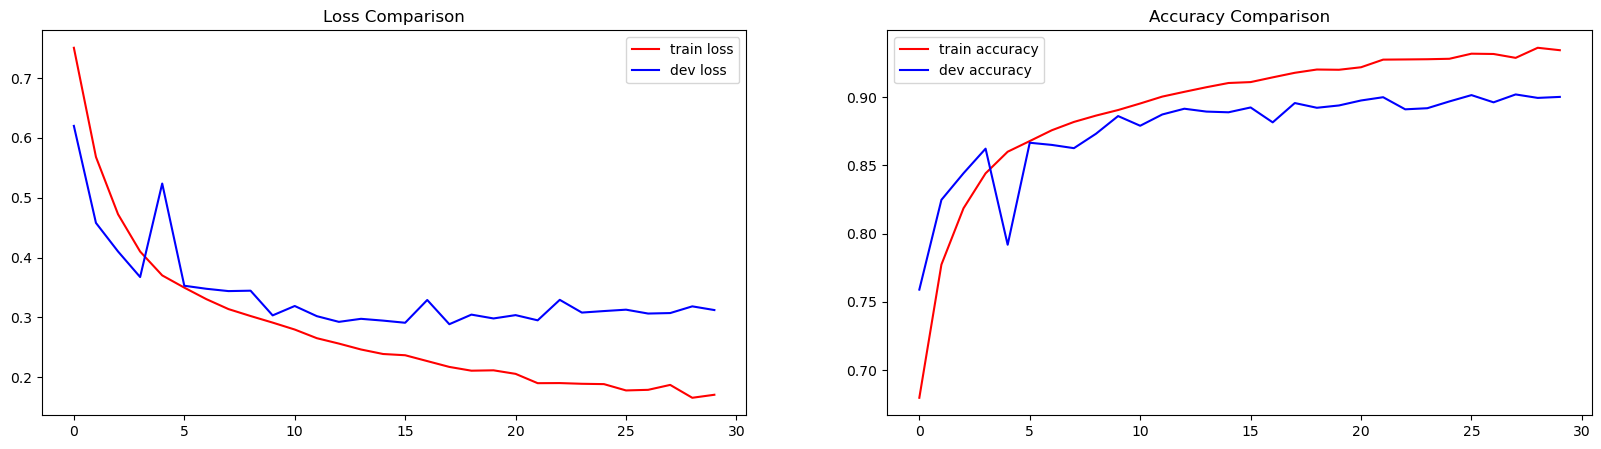

In [14]:
# High Bias is a characteristic of an underfitted model and we would observe low accuracies for both train and validation set
# High Variance is a characterisitic of an overfitted model and we would observe high accuracy for train set and low for validation set
# To check for bias and variance plit the graphs for accuracy 
# I have plotted for loss too, this helps in confirming if the loss is decreasing with each iteration - hence, the model is optimizing fine
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(results.history["loss"][:75], color='r', label = 'train loss')
axis[0].plot(results.history["val_loss"][:75], color='b', label = 'dev loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results.history["accuracy"][:75], color='r', label = 'train accuracy')
axis[1].plot(results.history["val_accuracy"], color='b', label = 'dev accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()
plt.show()

## Loading the saved (best) model

In [15]:
unet = tf.keras.models.load_model("UNet-checkpoint_callback")

In [16]:
unet.evaluate(X_valid, y_valid)

/apps/python/3.10-anaconda/envs/tensorflow/lib/python3.10/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


47/47 [==============================] - 3s 31ms/step - loss: 0.3073 - accuracy: 0.9020


[0.30726751685142517, 0.9019595384597778]

In [17]:
# Results of Validation Dataset
def VisualizeResults(index):
    """
    Given an index, will fetch the datapoint from the validation set and predicts its mask accordingly.
    At last, displays both in a figure.
    """
    img = X_valid[index]
    img = img[np.newaxis, ...]
    pred_y = unet.predict(img)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    fig, arr = plt.subplots(1, 3, figsize=(15, 15))
    arr[0].imshow(X_valid[index])
    arr[0].set_title('Processed Image')
    arr[1].imshow(y_valid[index,:,:,0])
    arr[1].set_title('Actual Masked Image ')
    arr[2].imshow(pred_mask[:,:,0])
    arr[2].set_title('Predicted Masked Image ')

1/1 [==============================] - 0s 27ms/step


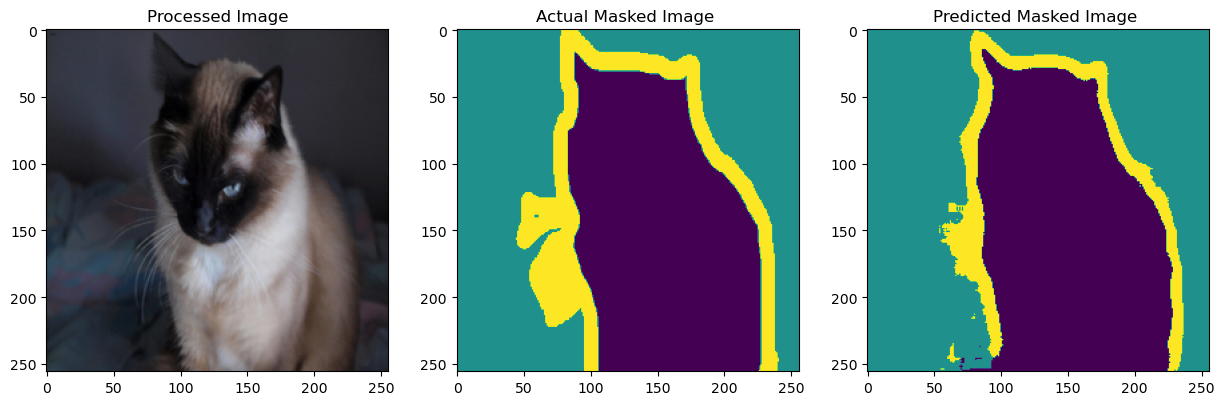

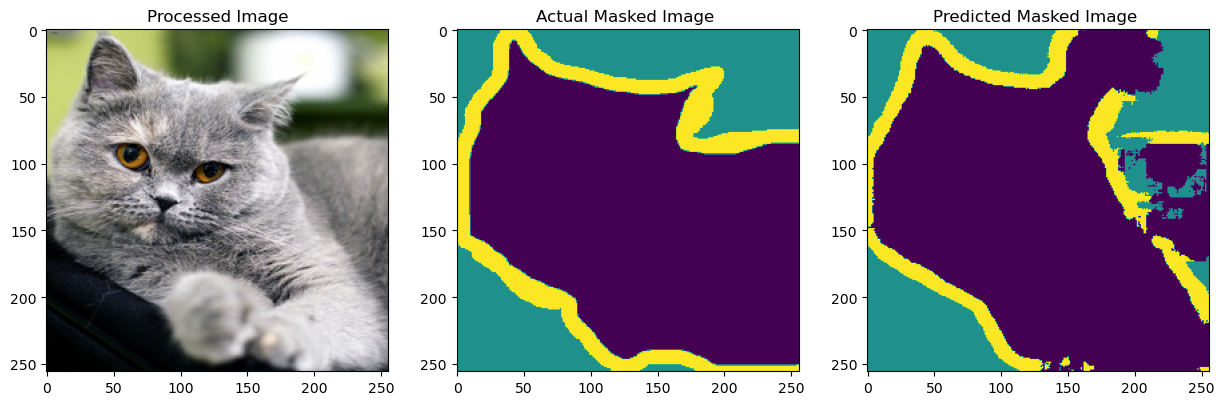

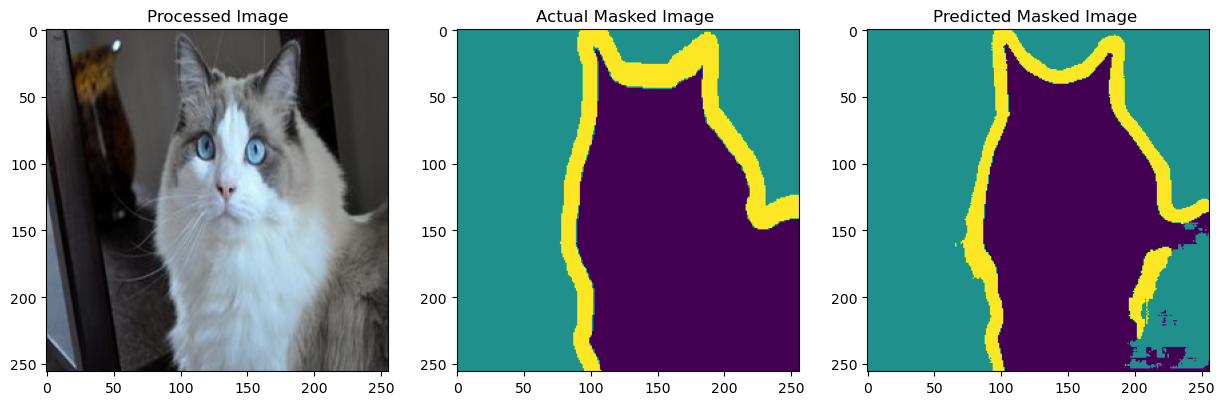

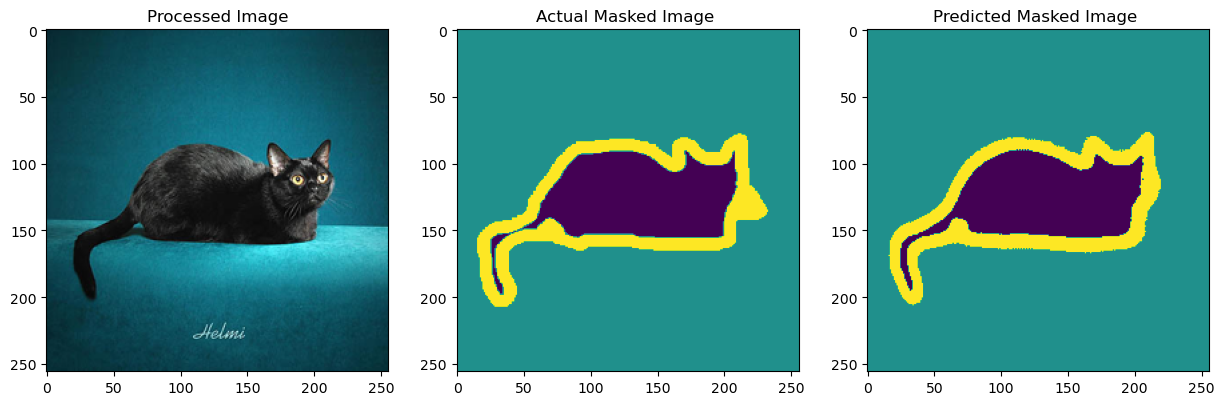

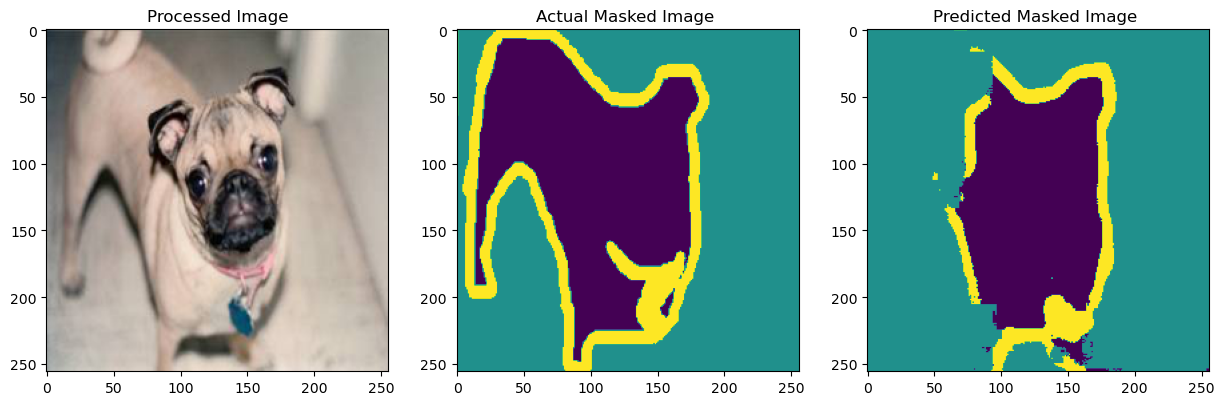

In [21]:
# Add any index to contrast the predicted mask with actual mask
random_indices = np.random.choice(len(X_valid), 5, replace=False)

for index in random_indices:
    VisualizeResults(index)